Growth model
State variables:
n - population
b - beta lactamase (has an effect on the antibiotics)
a - antibiotics 

Parameters:
- mumax, Ks, theta, etc. are parameters influencing growth and lysis.
- inh influences iota, which impacts growth and lysis rates.


Growth and Lysis Rates:
- Growth Rate is determined by mumax, g, and n.
- Lysis Rate is influenced by gamma, a, inh, and iota.

Equations:
- dndt (change in population): Growth minus lysis.
- dbdt (change in Bla): Lysis minus degradation.
- dadt (change in antibiotic): Degradation and interactions with Bla.


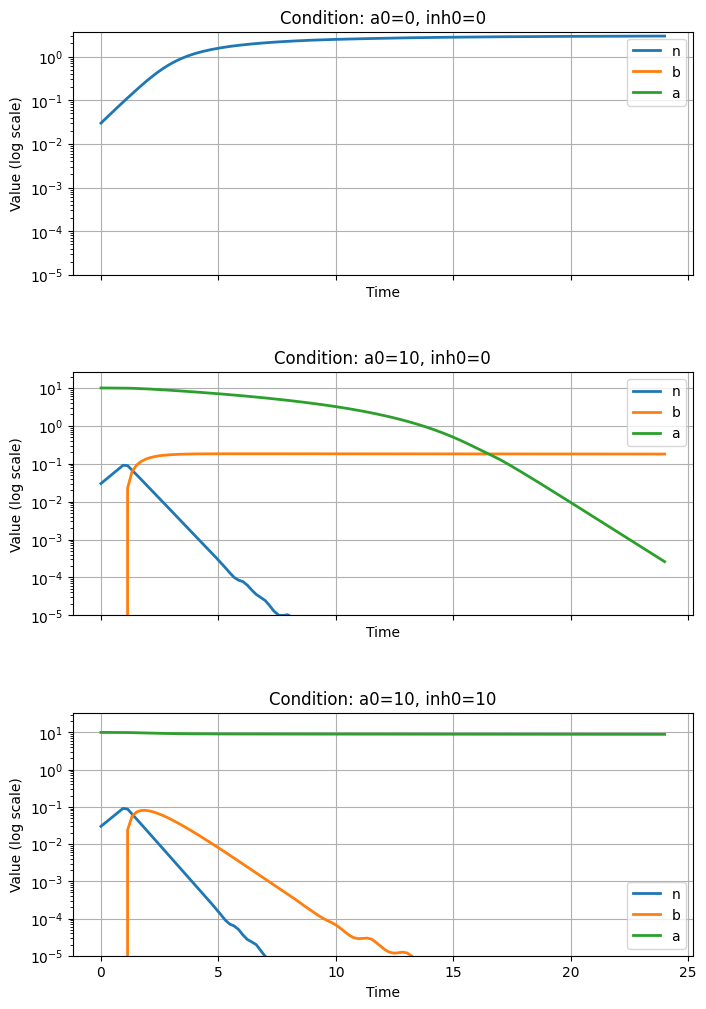

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import truncnorm


# Class for the growth model dynamics
class GrowthModel:
    def __init__(self, p, inh):
        self.p = p  # Model parameters
        self.inh = inh  # Inhibitor concentration
        self.initiate_lysis = False  # Track lysis initiation

    def __call__(self, t, y):
        y = np.maximum(y, 0)  # Ensure non-negative values
        n, b, a = y  # population (n), Bla (b), antibiotic (a)
        
        # Unpack model parameters
        mumax, Ks, theta, Ln, kappab, phimax, gamma, betamin, db, c = self.p

        # Constants for basal degradation and hill coefficients
        db0 = 0.001
        da0 = 0.001
        ha = 3
        hi = 3
        Ka = 1
        Ki = 15
        Nm = 3.0

        inh = self.inh
        iota = (inh**hi) / (1 + inh**hi) if inh > 0 else 0
        beta = betamin + c * (1 - betamin) * iota
        phi = phimax * (1 - c * iota)

        # Growth rate function with inhibition logic
        g = (1 / (1 + (n / (Nm * Ks))**theta)) * (1 - (n / Nm)) if Ks > 0 else 0

        # Lysis initiation
        l = 0
        if a > 0 or inh > 0:
            if not self.initiate_lysis and n > Ln:
                self.initiate_lysis = True
            if self.initiate_lysis:
                l = gamma * g * (a**ha + (inh / Ki)**hi) / (1 + a**ha + (inh / Ki)**hi)

        # Growth and lysis rates
        growth_rate = mumax * g * n
        lysis_rate = beta * l * n

        # Differential equations
        dndt = growth_rate - lysis_rate
        dbdt = lysis_rate - (db * iota + db0) * b
        dadt = -(kappab * b + phi * n) * a / (Ka + a) - da0 * a
        return [dndt, dbdt, dadt]

# Class for handling the simulation
class Simulation:
    def __init__(self, p, n0, a0, inh):
        self.p = p  # Model parameters
        self.n0 = n0  # Initial population
        self.a0 = a0  # Initial antibiotic concentration
        self.inh = inh  # Initial inhibitor concentration
        self.b0 = 0  # Initial Bla concentration (assumed zero)
        self.y0 = np.array([n0, self.b0, a0])  # Initial state

    def run(self, t_span=(0, 24), num_time_points=145):
        t_eval = np.linspace(t_span[0], t_span[1], num_time_points)
        model = GrowthModel(self.p, self.inh)
        sol = solve_ivp(model, t_span, self.y0, t_eval=t_eval)
        return sol.t, sol.y

# Class for plotting simulation results
class Plotter:
    def plot(self, t, results, conditions, variables=['n', 'b', 'a']):
        fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
        plt.subplots_adjust(hspace=0.4)

        # Loop through the results for each condition and plot
        for i, (result, (a0, inh0)) in enumerate(zip(results, conditions)):
            ax = axs[i]
            ax.set_title(f'Condition: a0={a0}, inh0={inh0}')
            for j, variable in enumerate(variables):
                ax.semilogy(t, result[j], label=variable, lw=2)

            ax.set_xlabel('Time')
            ax.set_ylabel('Value (log scale)')
            ax.set_ylim(bottom=1e-5)
            ax.grid(True)
            ax.legend()

        plt.show()

# Parameters
p = [1.2, 0.4, 2, 0.3, 5, 2, 3, 0.9, 1, 0.5]
n0 = 0.03
t_span = (0, 24)
num_time_points = 128

# Initial conditions for a and inh
conditions = [(0, 0), (10, 0), (10, 10)]

# Run simulations and store results
all_results = []
for a0, inh0 in conditions:
    sim = Simulation(p, n0, a0, inh0)
    t, results = sim.run(t_span=t_span, num_time_points=num_time_points)
    all_results.append(results)

# Plot the results
plotter = Plotter()
plotter.plot(t, all_results, conditions)

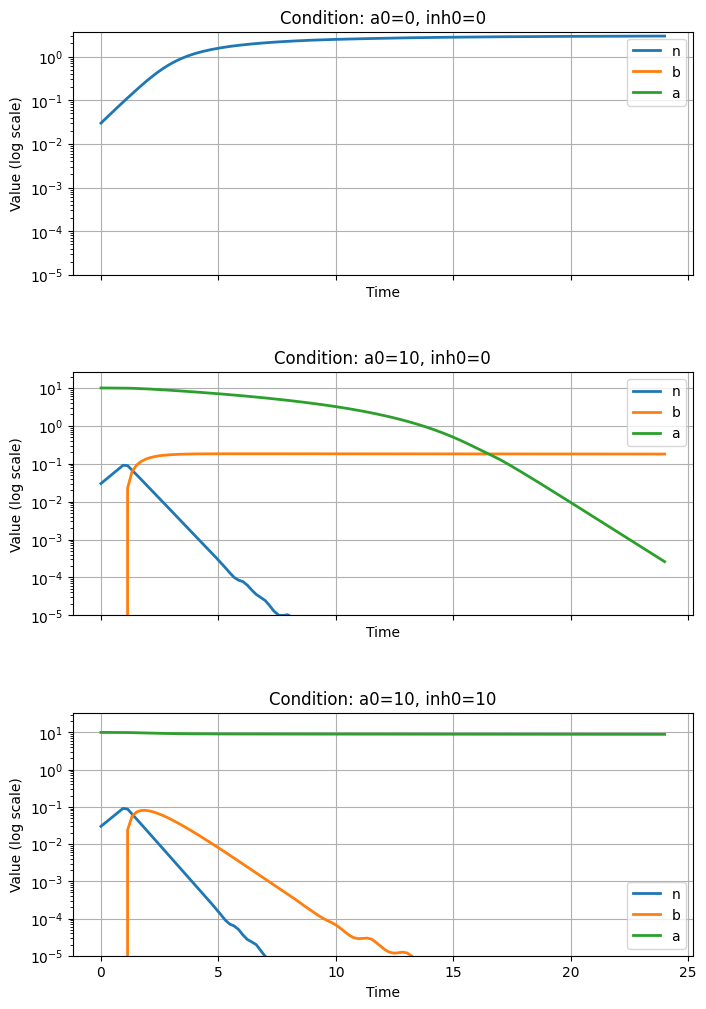

In [3]:

# Class for the growth model dynamics
class GrowthModel:
    def __init__(self, p, inh):
        self.p = p  # Model parameters
        self.inh = inh  # Inhibitor concentration
        self.initiate_lysis = False  # Track lysis initiation

    def __call__(self, t, y):
        y = np.maximum(y, 0)  # Ensure non-negative values
        n, b, a = y  # population (n), Bla (b), antibiotic (a)
        
        # Unpack model parameters
        mumax, Ks, theta, Ln, kappab, phimax, gamma, betamin, db, c = self.p

        # Constants for basal degradation and hill coefficients
        db0 = 0.001
        da0 = 0.001
        ha = 3
        hi = 3
        Ka = 1
        Ki = 15
        Nm = 3.0

        inh = self.inh
        iota = (inh**hi) / (1 + inh**hi) if inh > 0 else 0
        beta = betamin + c * (1 - betamin) * iota
        phi = phimax * (1 - c * iota)

        # Growth rate function with inhibition logic
        g = (1 / (1 + (n / (Nm * Ks))**theta)) * (1 - (n / Nm)) if Ks > 0 else 0

        # Lysis initiation
        l = 0
        if a > 0 or inh > 0:
            if not self.initiate_lysis and n > Ln:
                self.initiate_lysis = True
            if self.initiate_lysis:
                l = gamma * g * (a**ha + (inh / Ki)**hi) / (1 + a**ha + (inh / Ki)**hi)

        # Growth and lysis rates
        growth_rate = mumax * g * n
        lysis_rate = beta * l * n

        # Differential equations
        dndt = growth_rate - lysis_rate
        dbdt = lysis_rate - (db * iota + db0) * b
        dadt = -(kappab * b + phi * n) * a / (Ka + a) - da0 * a
        return [dndt, dbdt, dadt]

# Class for handling the simulation
class Simulation:
    def __init__(self, p, n0, a0, inh):
        self.p = p  # Model parameters
        self.n0 = n0  # Initial population
        self.a0 = a0  # Initial antibiotic concentration
        self.inh = inh  # Initial inhibitor concentration
        self.b0 = 0  # Initial Bla concentration (assumed zero)
        self.y0 = np.array([n0, self.b0, a0])  # Initial state

    def run(self, t_span=(0, 24), num_time_points=145):
        t_eval = np.linspace(t_span[0], t_span[1], num_time_points)
        model = GrowthModel(self.p, self.inh)
        sol = solve_ivp(model, t_span, self.y0, t_eval=t_eval)
        return sol.t, sol.y

# Class for plotting simulation results
class Plotter:
    def plot(self, t, results, conditions, variables=['n', 'b', 'a']):
        fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
        plt.subplots_adjust(hspace=0.4)

        # Loop through the results for each condition and plot
        for i, (result, (a0, inh0)) in enumerate(zip(results, conditions)):
            ax = axs[i]
            ax.set_title(f'Condition: a0={a0}, inh0={inh0}')
            for j, variable in enumerate(variables):
                ax.semilogy(t, result[j], label=variable, lw=2)

            ax.set_xlabel('Time')
            ax.set_ylabel('Value (log scale)')
            ax.set_ylim(bottom=1e-5)
            ax.grid(True)
            ax.legend()

        plt.show()

# Parameters
p = [1.2, 0.4, 2, 0.3, 5, 2, 3, 0.9, 1, 0.5]
n0 = 0.03
t_span = (0, 24)
num_time_points = 128

# Initial conditions for a and inh
conditions = [(0, 0), (10, 0), (10, 10)]

# Run simulations and store results
all_results = []
for a0, inh0 in conditions:
    sim = Simulation(p, n0, a0, inh0)
    t, results = sim.run(t_span=t_span, num_time_points=num_time_points)
    all_results.append(results)

# Plot the results
plotter = Plotter()
plotter.plot(t, all_results, conditions)

# Specific Conditions

### Condition 1: No Antibiotic (a0=0), No Inhibitor (inh0=0)

- **Bacterial population (n):**  steady growth in the bacterial population over time since there is no antibiotic or inhibitor to suppress it. 
- **Antibiotic (a):** Since a0=0, the antibiotic concentration will remain zero throughout.

### Condition 2: High Antibiotic (a0=10), No Inhibitor (inh0=0)

- **Bacterial population (n):** Bacterial population grows initially but then sharply decrease or stabilize as the antibiotic concentration affects it.
- **Biomolecule (b):** Increase in b as lysis occurs, since the biomolecule concentration is linked to the lysis process.
- **Antibiotic (a):** The antibiotic concentration (a) will decrease over time as it is consumed or degraded by the bacterial population and the model dynamics.

### Condition 3: High Antibiotic (a0=10), High Inhibitor (inh0=10)

- **Bacterial population (n):** Bacterial population decreases quickly due to both the antibiotic and inhibitor acting on it. 
- **Antibiotic (a):** Like in Condition 2, the antibiotic concentration will decrease.

### 1. **Bacterial Population (`n`)**
   - **Condition 1 (`a0=0, inh0=0`)**: 
     - Bacterial population (`n`) grows steadily over time and reaches a saturation point. This is an expected since there is no antibiotic 
     or inhibitor present.
   - **Condition 2 (`a0=10, inh0=0`)**:
     - In some sets (e.g., Sets 2, 5, 10), the bacterial population grows initially but then declines as the antibiotic starts to take effect. This reflects the antibiotic killing off the bacterial population after an initial phase of growth.
   - **Condition 3 (`a0=10, inh0=10`)**:
     - In most sets, the bacterial population declines rapidly from the start. The presence of both the antibiotic and the inhibitor enhances the killing effect.

### 2. **Beta lactamase (`b`)**
   - **Condition 1 (`a0=0, inh0=0`)**:
     - The biomolecule (`b`) concentration stays relatively low across all sets. Without the presence of stressors (antibiotic or inhibitor), there's minimal lysis, meaning not much biomolecule is released.
   - **Condition 2 (`a0=10, inh0=0`)**:
     - In sets where the antibiotic causes bacterial death, the biomolecule concentration rises significantly. This is because lysis is triggered by the antibiotic, releasing the biomolecule into the environment.
   - **Condition 3 (`a0=10, inh0=10`)**:
     - Here, the biomolecule concentration also rises, but in some sets, the biomolecule drops after an initial increase. This could suggest rapid degradation of the biomolecule due to the combined effect of antibiotic and inhibitor or the swift depletion of bacteria.

### 3. **Antibiotic Concentration (`a`)**
   - **Condition 1 (`a0=0, inh0=0`)**:
     - As expected, the antibiotic concentration remains zero in all sets under this condition, as no antibiotic is introduced.
   - **Condition 2 (`a0=10, inh0=0`)**:
     - The antibiotic concentration starts high and declines steadily over time as it is consumed or degraded. The rate of decline varies across sets, depending on the sampled parameters.
   - **Condition 3 (`a0=10, inh0=10`)**:
     - Similar to Condition 2, the antibiotic concentration decreases over time.

Simulations completed: 1000/10000
Simulations completed: 2000/10000
Simulations completed: 3000/10000
Simulations completed: 4000/10000
Simulations completed: 5000/10000
Simulations completed: 6000/10000
Simulations completed: 7000/10000
Simulations completed: 8000/10000
Simulations completed: 9000/10000
Simulations completed: 10000/10000


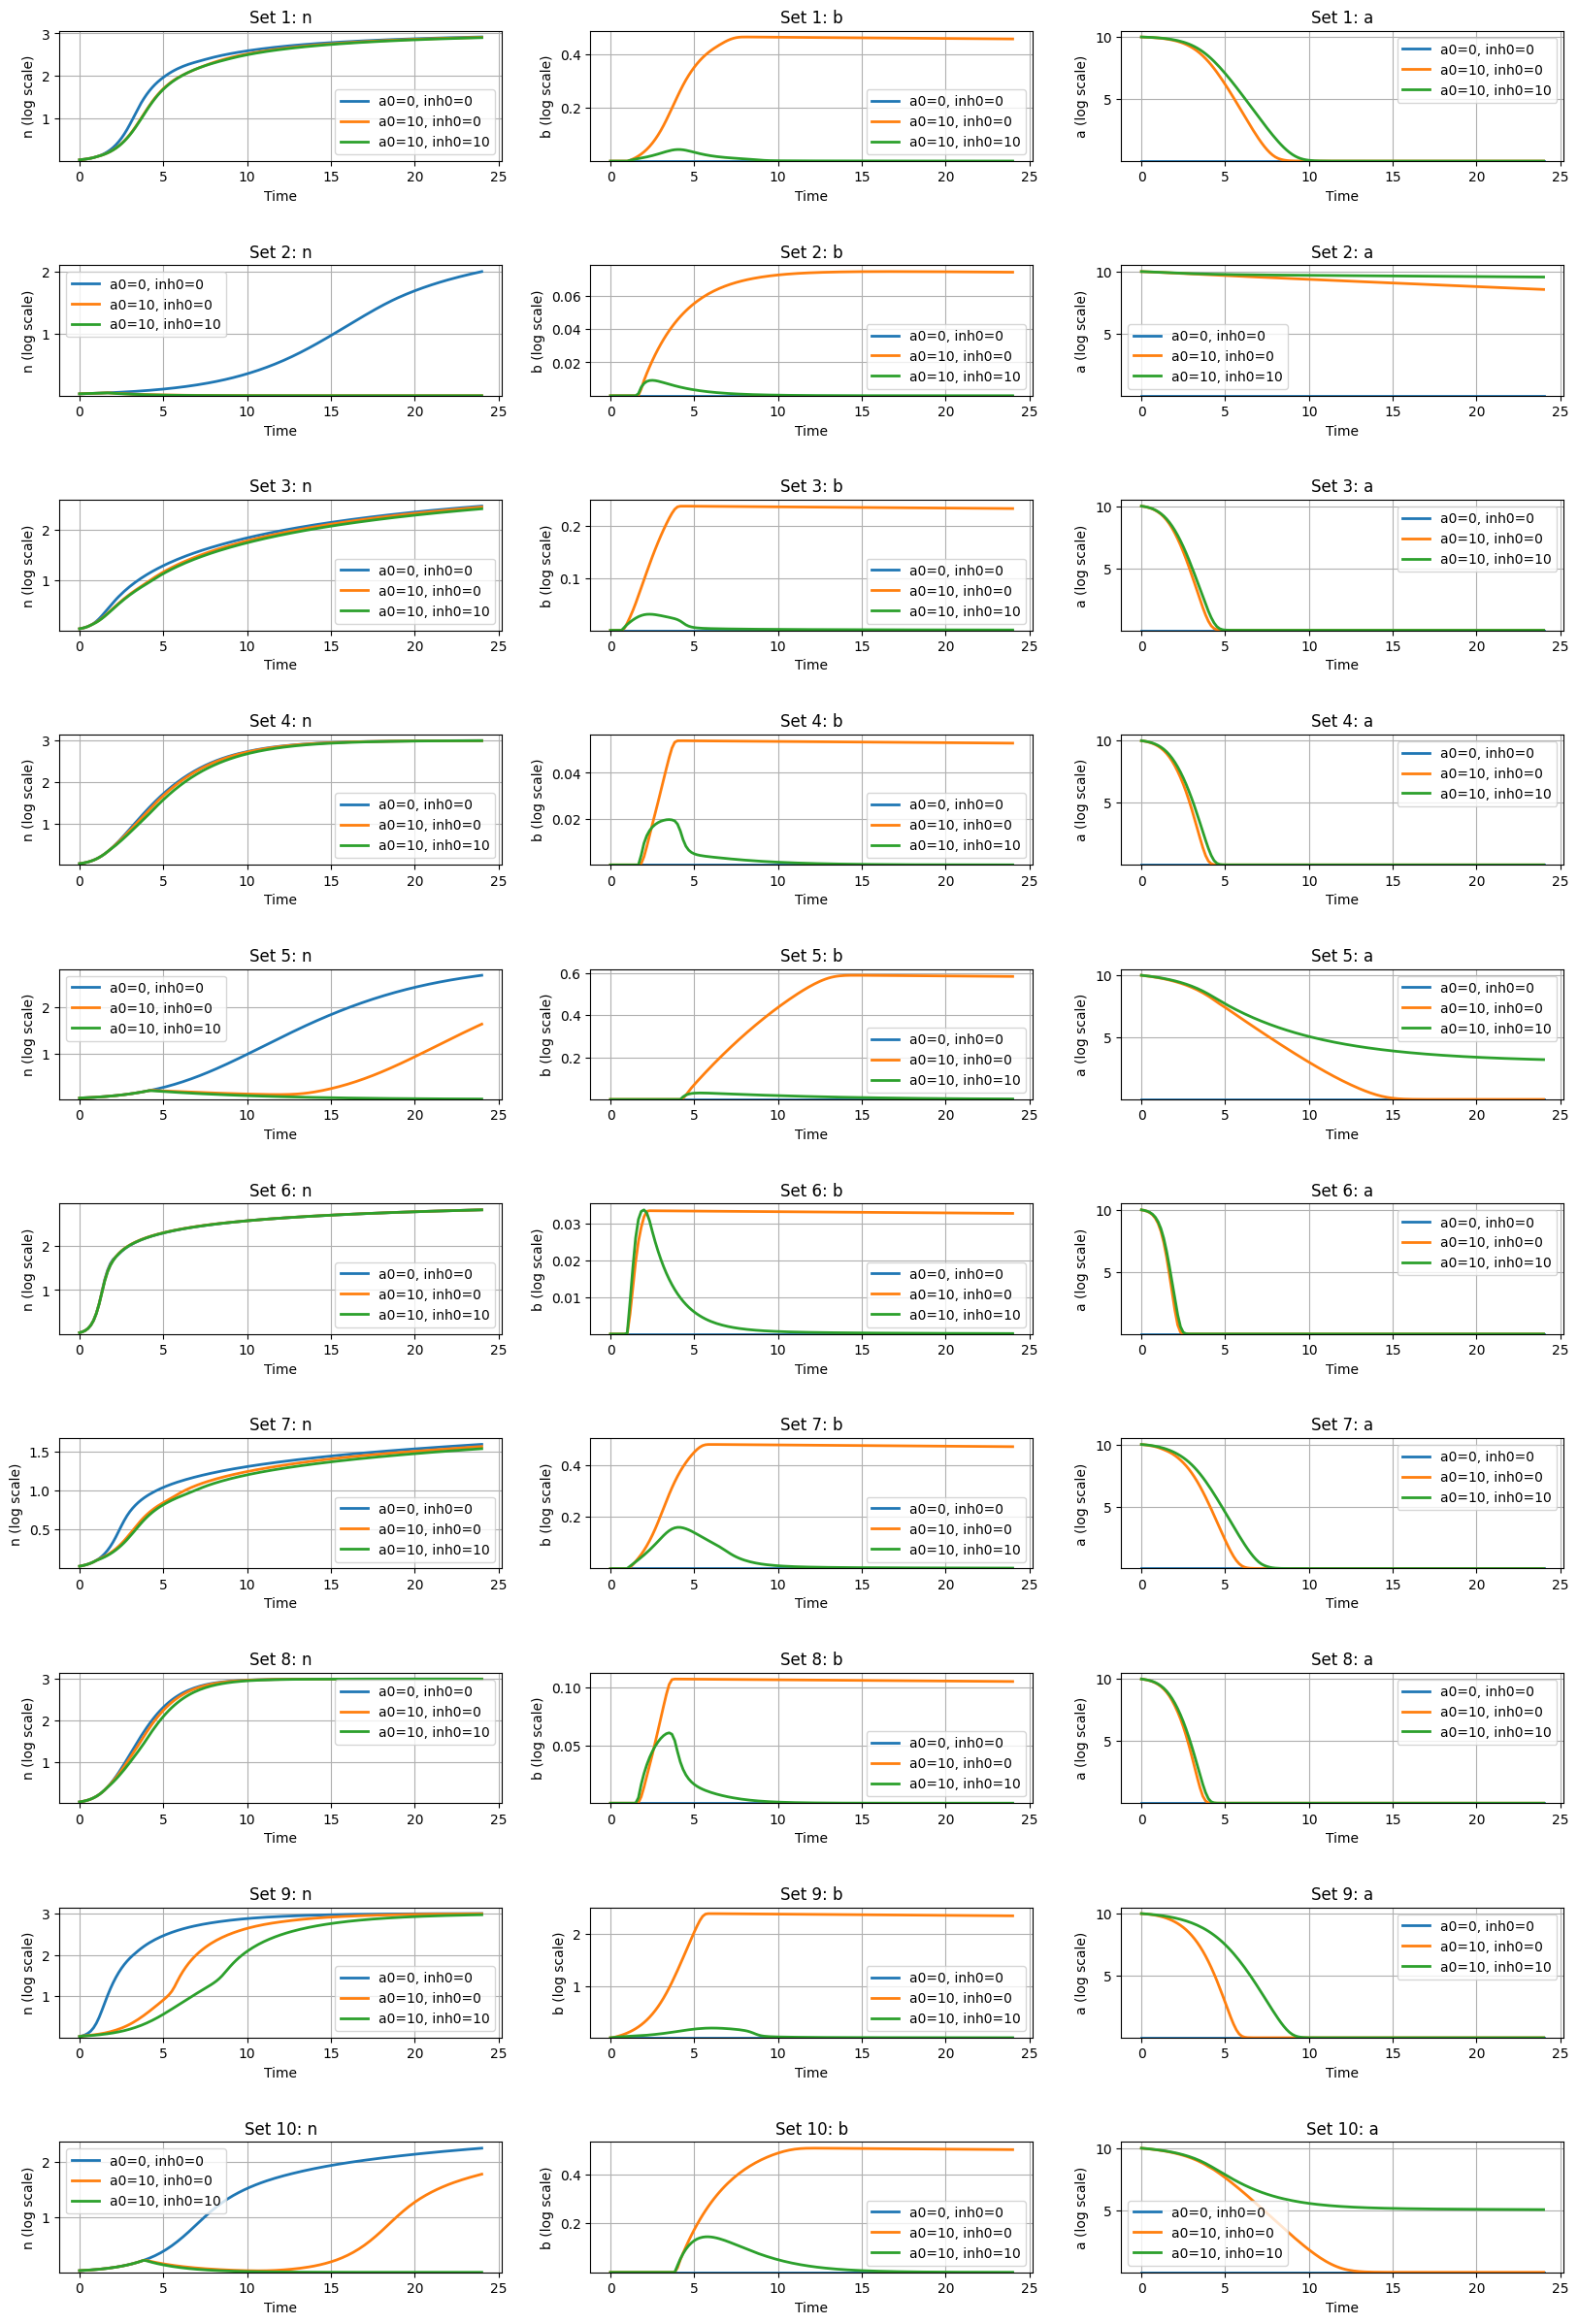

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import truncnorm

# Function to sample from a truncated normal distribution
def sample_truncated_normal(mean, sd, low, upp, size=None):
    a, b = (low - mean) / sd, (upp - mean) / sd
    return truncnorm.rvs(a, b, loc=mean, scale=sd, size=size)

# Class to handle parameter sampling
class ParameterSampler:
    def __init__(self, param_specs, seed=None):
        self.param_specs = param_specs
        if seed is not None:
            np.random.seed(seed)  # Set the seed for reproducibility

    def sample_parameters(self):
        p = []
        for key in ['mumax', 'Ks', 'theta', 'Ln', 'kappab', 'phimax', 'gamma', 'betamin', 'db', 'c']:
            spec = self.param_specs[key]
            value = sample_truncated_normal(spec['mean'], spec['sd'], spec['low'], spec['high'])
            p.append(value)
        return p

# Class to handle simulation runs
class SimulationRunner:
    def __init__(self, num_simulations, n0, conditions, t_eval, param_specs, seed=None):
        self.num_simulations = num_simulations
        self.n0 = n0
        self.conditions = conditions
        self.t_eval = t_eval
        self.param_sampler = ParameterSampler(param_specs, seed=seed)
        self.parameters = np.zeros((num_simulations, 10))
        self.curves = np.zeros((num_simulations, len(conditions), 3, len(t_eval)))

    def simulate(self, p, n0, a0, inh0):
        # Define your growth model and the simulation logic
        sim = Simulation(p, n0, a0, inh0)
        _, results = sim.run(t_span=(0, 24), num_time_points=len(self.t_eval))
        return results

    def run_all_simulations(self):
        for i in range(self.num_simulations):
            # Sample parameters for this simulation
            p = self.param_sampler.sample_parameters()
            self.parameters[i] = p

            # Run simulations under the specified conditions
            for j, (a0, inh0) in enumerate(self.conditions):
                simulated = self.simulate(p, self.n0, a0, inh0)
                self.curves[i, j] = simulated

            if (i + 1) % 1000 == 0:
                print(f'Simulations completed: {i + 1}/{self.num_simulations}')

        # Save results to files
        np.savez_compressed('data/simulated/curves10k.npz', curves=self.curves, t_eval=self.t_eval)
        np.save('data/simulated/parameters.npy', self.parameters)

    def plot_results(self, num_sets_to_plot=10):
        variables = ['n', 'b', 'a']
        fig, axs = plt.subplots(num_sets_to_plot, 3, figsize=(20, 30))
        plt.subplots_adjust(hspace=0.8)

        for i in range(num_sets_to_plot):
            for j in range(3):  # Variables n, b, a
                ax = axs[i, j]
                variable = variables[j]

                for k, (a0, inh0) in enumerate(self.conditions):
                    label = f'a0={a0}, inh0={inh0}'
                    ax.plot(self.t_eval, self.curves[i, k, j], label=label, lw=2)

                ax.set_ylim(bottom=1e-5)
                ax.set_xlabel('Time')
                ax.set_ylabel(f'{variable} (log scale)')
                ax.set_title(f'Set {i+1}: {variable}')
                ax.grid(True)
                ax.legend()

        plt.show()

# Simulation parameters
param_specs = {
    'mumax':   {'mean': 1.2,  'sd': 4,   'low': 0.2, 'high': 3},
    'Ks':      {'mean': 0.2,  'sd': 0.5, 'low': 0.1, 'high': 0.6},
    'theta':   {'mean': 3,    'sd': 5,   'low': 0.5, 'high': 6},
    'Ln':      {'mean': 0.2,  'sd': 0.4, 'low': 0,   'high': 0.8},
    'kappab':  {'mean': 2,    'sd': 10,  'low': 0,   'high': 4},
    'phimax':  {'mean': 4,    'sd': 10,  'low': 0,   'high': 8},
    'gamma':   {'mean': 2,    'sd': 3.2, 'low': 0,   'high': 4},
    'betamin': {'mean': 0.5,  'sd': 10,  'low': 0,   'high': 1},
    'db':      {'mean': 2.5,  'sd': 3,   'low': 0.5, 'high': 5},
    'c':       {'mean': 0.15, 'sd': 0.05,'low': 0,   'high': 0.3}
}

num_simulations = 10000
n0 = 0.03
conditions = [(0, 0), (10, 0), (10, 10)]
t_eval = np.linspace(0, 24, 145)
seed = 42  # Set a seed for reproducibility

# Initialize and run simulations
simulation_runner = SimulationRunner(num_simulations, n0, conditions, t_eval, param_specs, seed=seed)
simulation_runner.run_all_simulations()

# Plot some results
simulation_runner.plot_results(num_sets_to_plot=10)

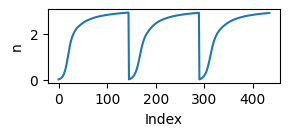

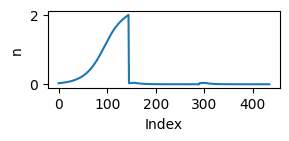

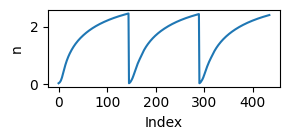

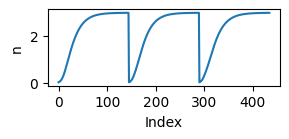

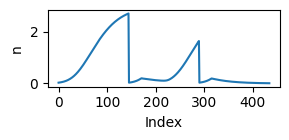

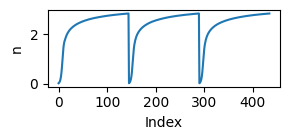

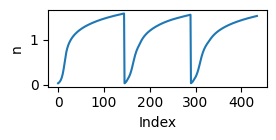

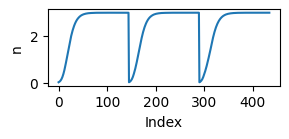

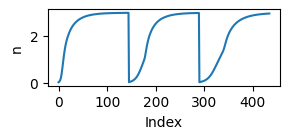

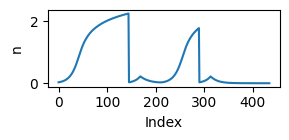

(10000, 435)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data_array = np.load('data/simulated/curves10k.npz')['curves']

# Define conditions
conditions = [(0, 0), (10, 0), (10, 10)]
num_strains_to_display = 10  # Number of strains to display

# Prepare an empty numpy array to store all concatenated 'n' values
all_n_values = np.empty((data_array.shape[0], (data_array.shape[1])*(data_array.shape[3])))

# Iterate over all strains
for strain_index in range(data_array.shape[0]):
    # Extract and concatenate the 'n' values for all conditions
    all_n_values[strain_index, :] = np.concatenate([data_array[strain_index, condition_index, 0, :] for condition_index in range(data_array.shape[1])])

    # If this is one of the top strains, create a figure and plot the curves
    if strain_index < num_strains_to_display:
        fig, ax = plt.subplots(figsize=(3, 1.5))

        # Plot the concatenated 'n' curve in this figure
        ax.plot(all_n_values[strain_index, :])

        # Set title of this figure to the current strain
        ax.set_xlabel('Index')
        ax.set_ylabel('n')

        # Show the figure
        plt.tight_layout()
        plt.show()

print(all_n_values.shape)


Simulations completed: 1000/10000
Simulations completed: 2000/10000
Simulations completed: 3000/10000
Simulations completed: 4000/10000
Simulations completed: 5000/10000
Simulations completed: 6000/10000
Simulations completed: 7000/10000
Simulations completed: 8000/10000
Simulations completed: 9000/10000
Simulations completed: 10000/10000


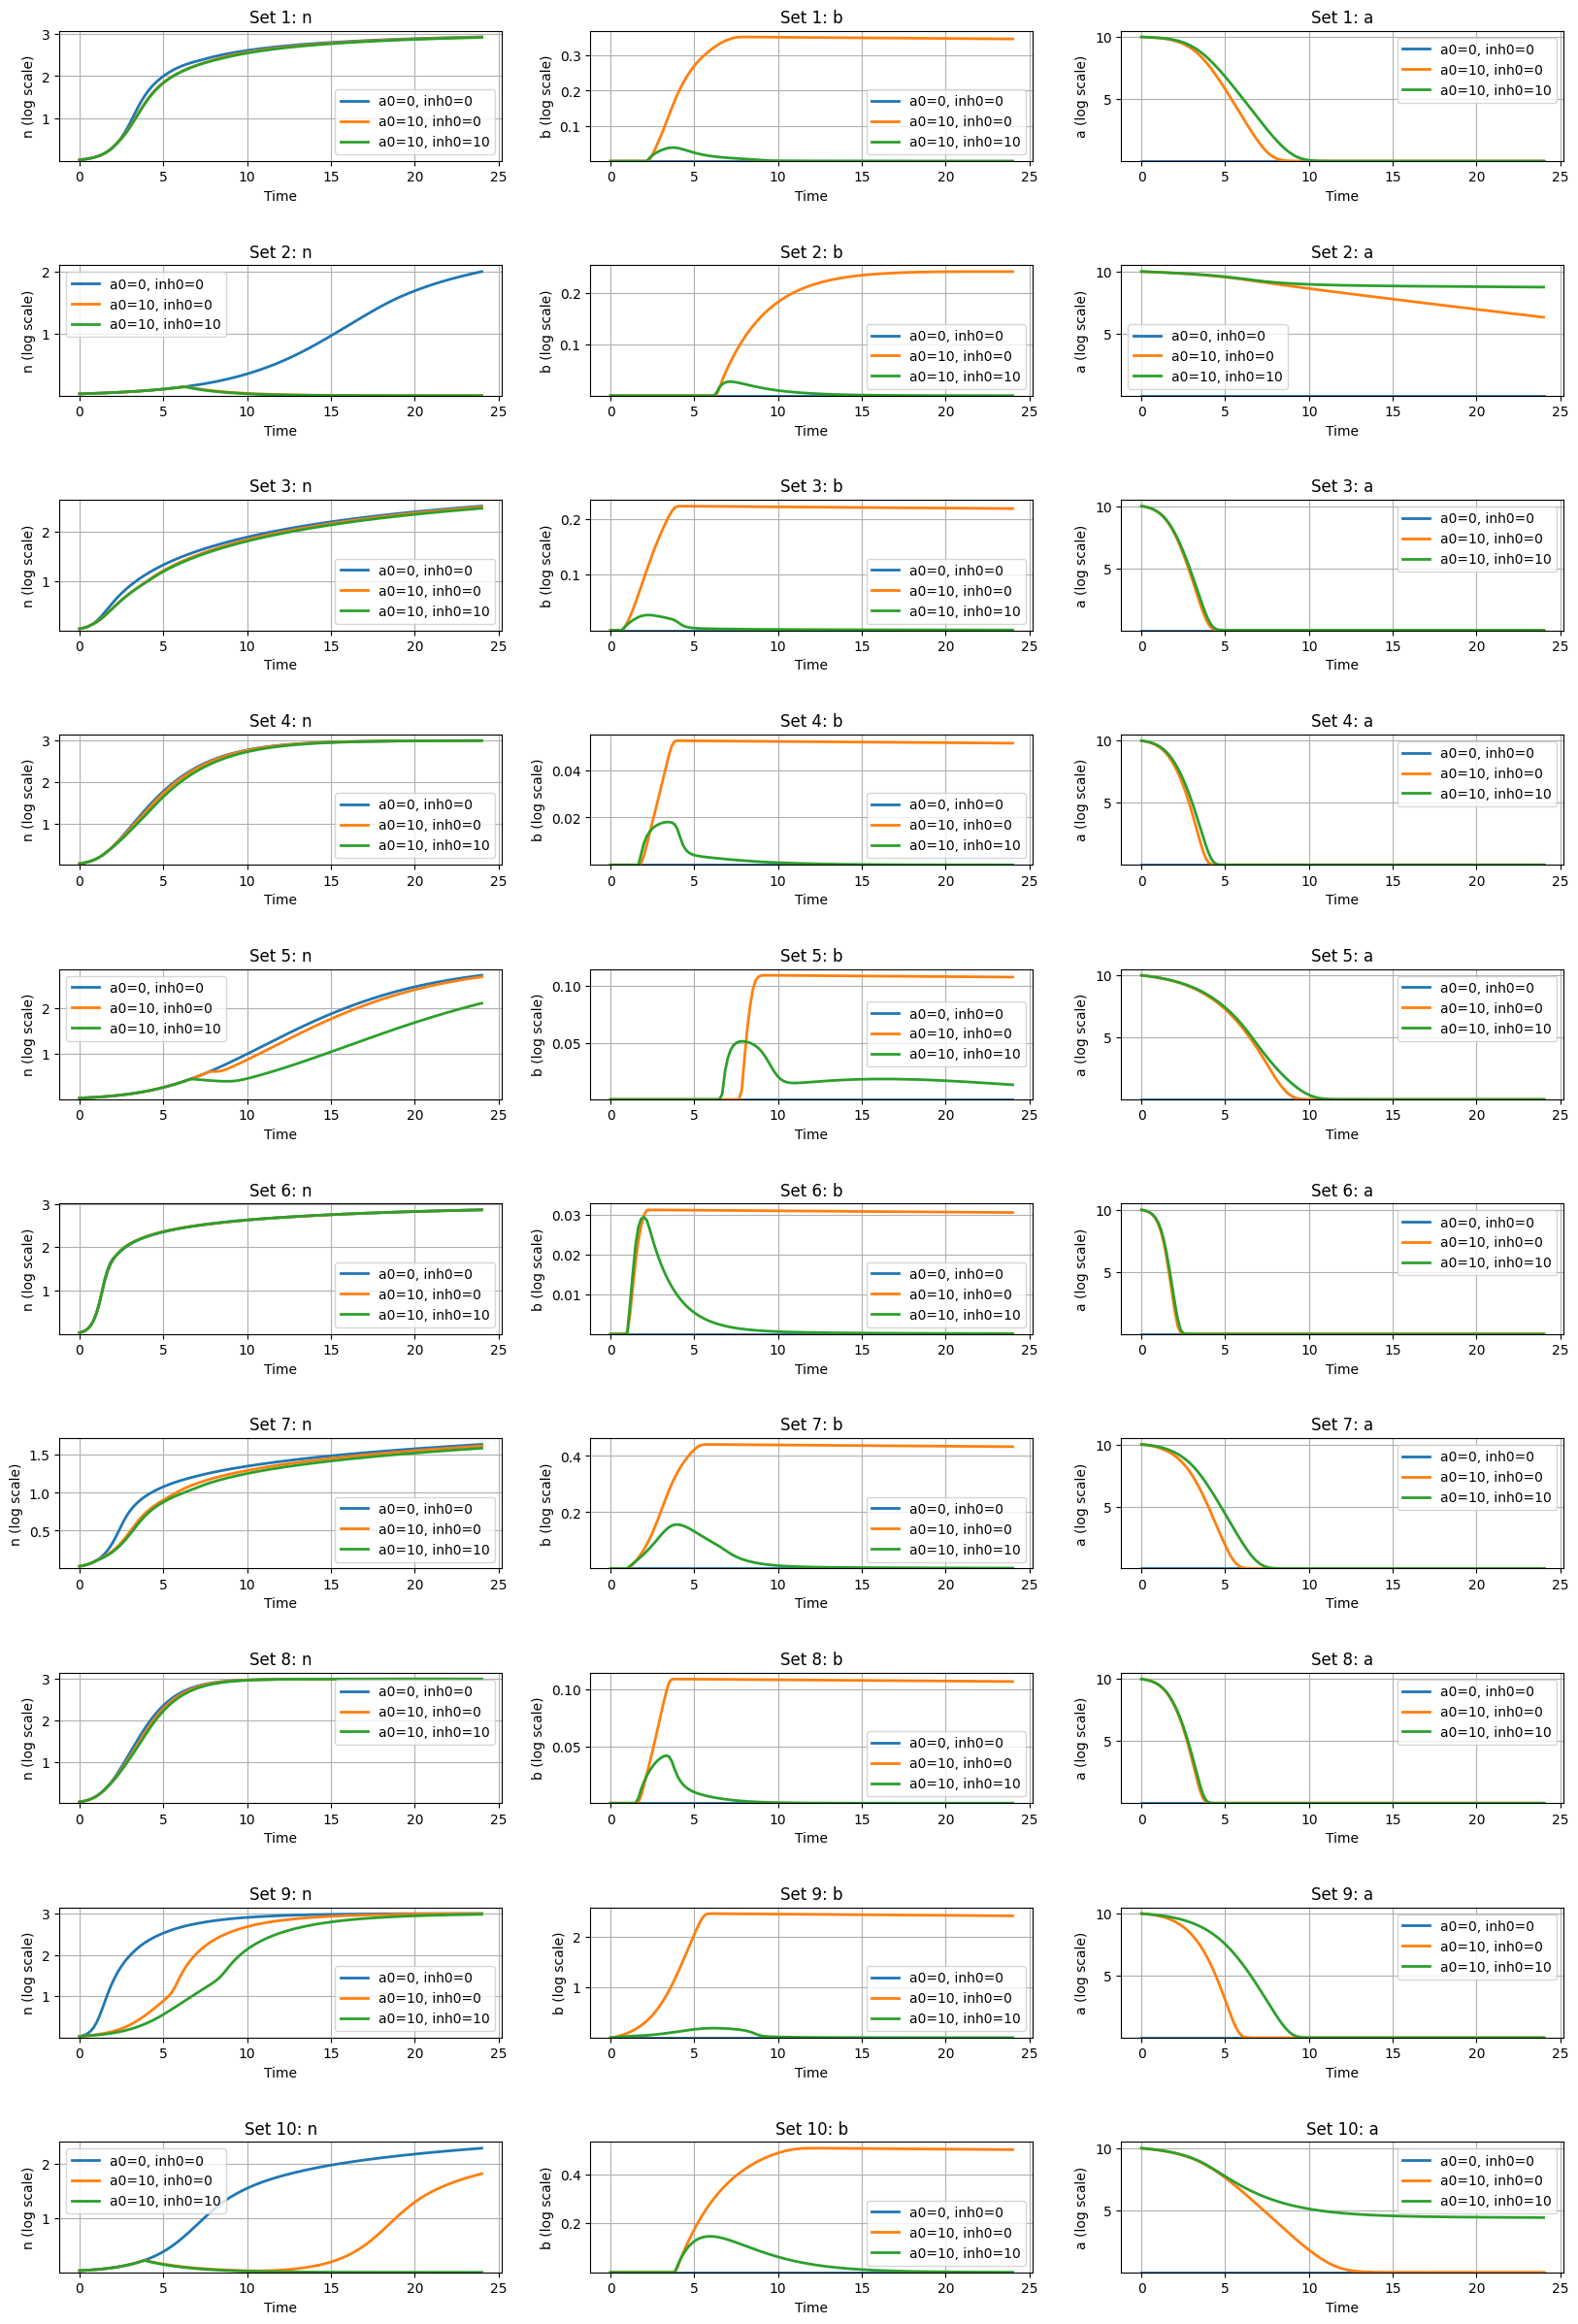

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import truncnorm
import os

# Function to sample from a specified distribution
def sample_parameters(distribution, param_specs):
    if distribution == 'truncnorm':
        return [truncnorm.rvs((spec['low'] - spec['mean']) / spec['sd'], 
                              (spec['high'] - spec['mean']) / spec['sd'], 
                              loc=spec['mean'], scale=spec['sd']) for spec in param_specs.values()]
    elif distribution == 'uniform':
        return [np.random.uniform(spec['low'], spec['high']) for spec in param_specs.values()]
    else:
        raise ValueError(f"Unknown distribution type: {distribution}")

# Class to handle simulation runs elegantly
class SimulationRunner:
    def __init__(self, num_simulations, n0, conditions, t_eval, param_specs, distribution, seed=None):
        self.num_simulations = num_simulations
        self.n0 = n0
        self.conditions = conditions
        self.t_eval = t_eval
        self.param_specs = param_specs
        self.distribution = distribution
        self.folder_name = f"simulated_{distribution}"
        
        if seed is not None:
            np.random.seed(seed)
        
        os.makedirs(f'data/{self.folder_name}', exist_ok=True)
        self.parameters = np.zeros((num_simulations, len(param_specs)))
        self.curves = np.zeros((num_simulations, len(conditions), 3, len(t_eval)))

    def simulate(self, p, n0, a0, inh0):
        sim = Simulation(p, n0, a0, inh0)
        _, results = sim.run(t_span=(0, 24), num_time_points=len(self.t_eval))
        return results

    def run_all_simulations(self):
        for i in range(self.num_simulations):
            p = sample_parameters(self.distribution, self.param_specs)
            self.parameters[i] = p

            for j, (a0, inh0) in enumerate(self.conditions):
                self.curves[i, j] = self.simulate(p, self.n0, a0, inh0)

            if (i + 1) % 1000 == 0:
                print(f'Simulations completed: {i + 1}/{self.num_simulations}')

        np.savez_compressed(f'data/{self.folder_name}/curves10k.npz', curves=self.curves, t_eval=self.t_eval)
        np.save(f'data/{self.folder_name}/parameters.npy', self.parameters)

    def plot_results(self, num_sets_to_plot=10):
        variables = ['n', 'b', 'a']
        fig, axs = plt.subplots(num_sets_to_plot, 3, figsize=(20, 30))
        plt.subplots_adjust(hspace=0.8)

        for i in range(num_sets_to_plot):
            for j, variable in enumerate(variables):
                ax = axs[i, j]
                for k, (a0, inh0) in enumerate(self.conditions):
                    ax.plot(self.t_eval, self.curves[i, k, j], label=f'a0={a0}, inh0={inh0}', lw=2)
                ax.set_ylim(bottom=1e-5)
                ax.set_xlabel('Time')
                ax.set_ylabel(f'{variable} (log scale)')
                ax.set_title(f'Set {i+1}: {variable}')
                ax.grid(True)
                ax.legend()

        plt.show()

# Define parameter specifications
param_specs = {
    'mumax':   {'mean': 1.2, 'sd': 4, 'low': 0.2, 'high': 3},
    'Ks':      {'mean': 0.2, 'sd': 0.5, 'low': 0.1, 'high': 0.6},
    'theta':   {'mean': 3, 'sd': 5, 'low': 0.5, 'high': 6},
    'Ln':      {'mean': 0.2, 'sd': 0.4, 'low': 0, 'high': 0.8},
    'kappab':  {'mean': 2, 'sd': 10, 'low': 0, 'high': 4},
    'phimax':  {'mean': 4, 'sd': 10, 'low': 0, 'high': 8},
    'gamma':   {'mean': 2, 'sd': 3.2, 'low': 0, 'high': 4},
    'betamin': {'mean': 0.5, 'sd': 10, 'low': 0, 'high': 1},
    'db':      {'mean': 2.5, 'sd': 3, 'low': 0.5, 'high': 5},
    'c':       {'mean': 0.15, 'sd': 0.05, 'low': 0, 'high': 0.3}
}

num_simulations = 10000
n0 = 0.03
conditions = [(0, 0), (10, 0), (10, 10)]
t_eval = np.linspace(0, 24, 145)
distribution = 'uniform'  # Change to 'uniform' to use uniform distribution
seed = 42

simulation_runner = SimulationRunner(num_simulations, n0, conditions, t_eval, param_specs, distribution, seed=seed)
simulation_runner.run_all_simulations()
simulation_runner.plot_results(num_sets_to_plot=10)


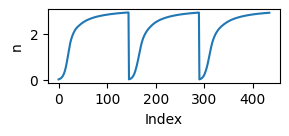

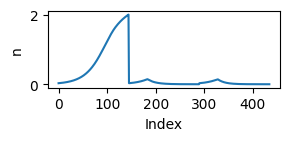

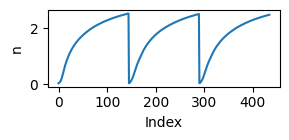

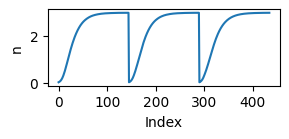

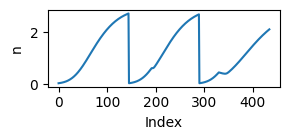

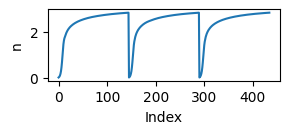

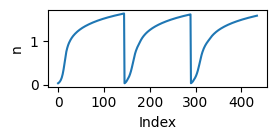

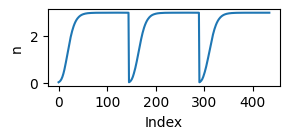

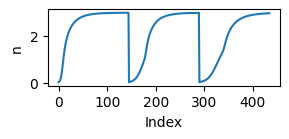

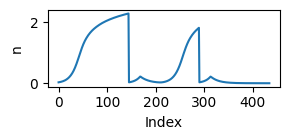

(10000, 435)


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data_array = np.load('data/simulated_uniform/curves10k.npz')['curves']

# Define conditions
conditions = [(0, 0), (10, 0), (10, 10)]
num_strains_to_display = 10  # Number of strains to display

# Prepare an empty numpy array to store all concatenated 'n' values
all_n_values = np.empty((data_array.shape[0], (data_array.shape[1])*(data_array.shape[3])))

# Iterate over all strains
for strain_index in range(data_array.shape[0]):
    # Extract and concatenate the 'n' values for all conditions
    all_n_values[strain_index, :] = np.concatenate([data_array[strain_index, condition_index, 0, :] for condition_index in range(data_array.shape[1])])

    # If this is one of the top strains, create a figure and plot the curves
    if strain_index < num_strains_to_display:
        fig, ax = plt.subplots(figsize=(3, 1.5))

        # Plot the concatenated 'n' curve in this figure
        ax.plot(all_n_values[strain_index, :])

        # Set title of this figure to the current strain
        ax.set_xlabel('Index')
        ax.set_ylabel('n')

        # Show the figure
        plt.tight_layout()
        plt.show()

print(all_n_values.shape)


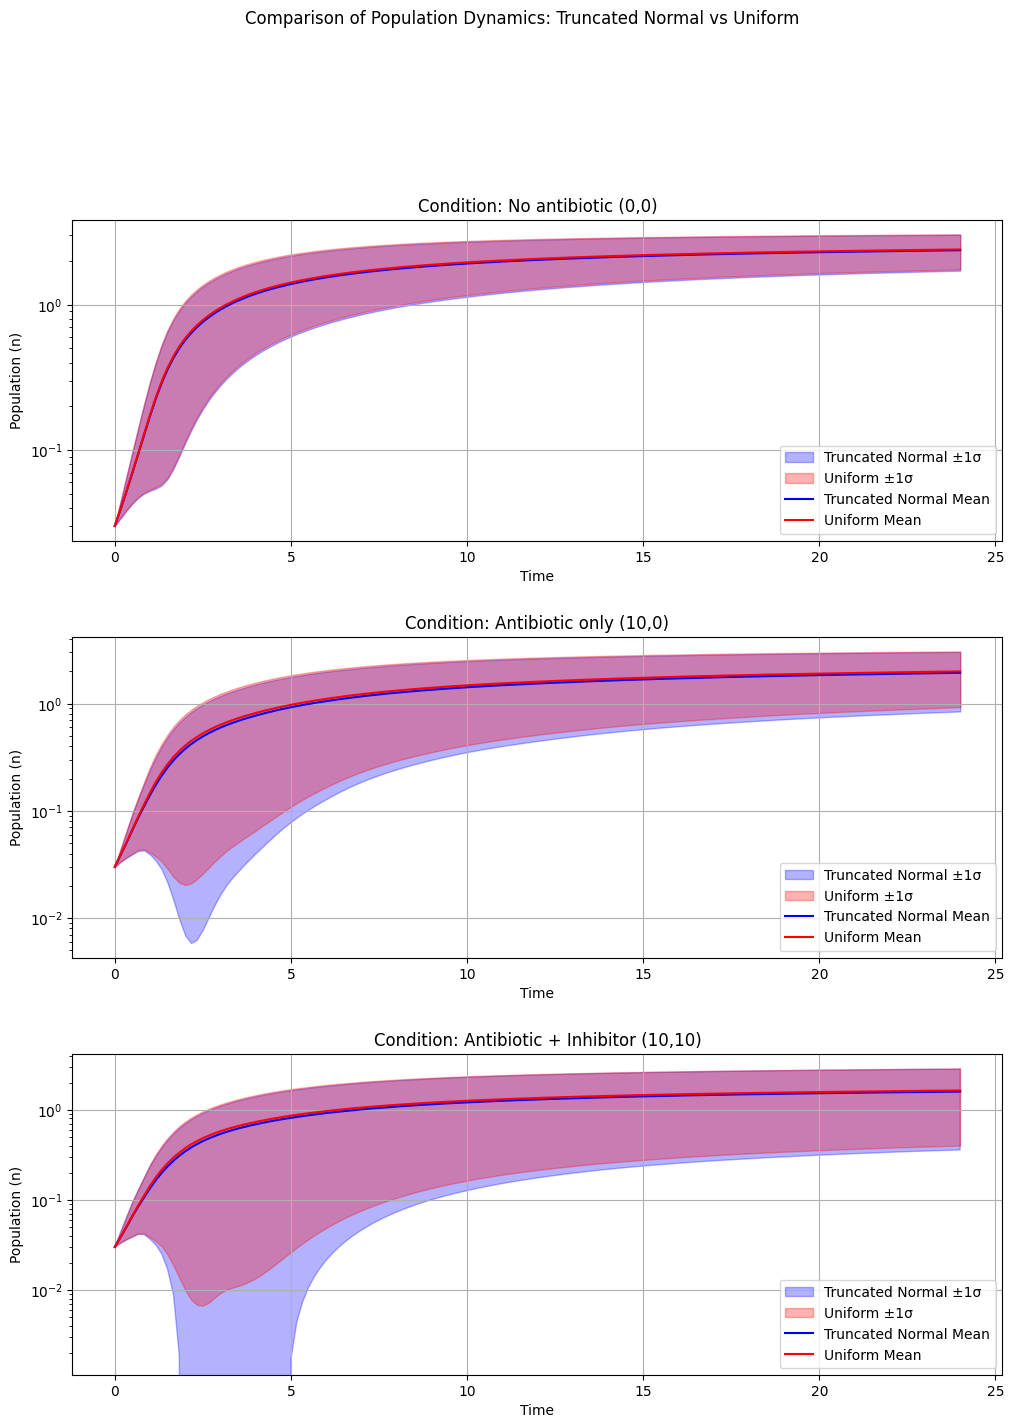

Statistical comparison:

Condition: No antibiotic (0,0)
Truncated Normal - Final mean: 2.370, std: 0.657
Uniform         - Final mean: 2.399, std: 0.651
KS test - statistic: 0.026, p-value: 1.879e-03

Condition: Antibiotic only (10,0)
Truncated Normal - Final mean: 1.935, std: 1.090
Uniform         - Final mean: 1.995, std: 1.069
KS test - statistic: 0.029, p-value: 4.714e-04

Condition: Antibiotic + Inhibitor (10,10)
Truncated Normal - Final mean: 1.592, std: 1.234
Uniform         - Final mean: 1.636, std: 1.236
KS test - statistic: 0.023, p-value: 8.374e-03


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
truncated_data = np.load('data/simulated/curves10k.npz')['curves']
uniform_data = np.load('data/simulated_uniform/curves10k.npz')['curves']

# Function to compute summary statistics
def compute_statistics(data):
    # Compute mean, std, min, max for each timepoint
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    return mean, std, min_vals, max_vals

# Create comparison plots for each condition
conditions = ['No antibiotic (0,0)', 'Antibiotic only (10,0)', 'Antibiotic + Inhibitor (10,10)']
t = np.linspace(0, 24, truncated_data.shape[3])

fig, axes = plt.subplots(3, 1, figsize=(12, 15))
plt.subplots_adjust(hspace=0.3)

for i in range(3):
    # Get statistics for population (n) for both distributions
    trunc_mean, trunc_std, trunc_min, trunc_max = compute_statistics(truncated_data[:, i, 0, :])
    unif_mean, unif_std, unif_min, unif_max = compute_statistics(uniform_data[:, i, 0, :])
    
    ax = axes[i]
    
    # Plot mean and standard deviation ranges
    ax.fill_between(t, trunc_mean - trunc_std, trunc_mean + trunc_std, 
                   alpha=0.3, color='blue', label='Truncated Normal ±1σ')
    ax.fill_between(t, unif_mean - unif_std, unif_mean + unif_std, 
                   alpha=0.3, color='red', label='Uniform ±1σ')
    
    # Plot means
    ax.plot(t, trunc_mean, 'b-', label='Truncated Normal Mean')
    ax.plot(t, unif_mean, 'r-', label='Uniform Mean')
    
    ax.set_yscale('log')
    ax.set_title(f'Condition: {conditions[i]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population (n)')
    ax.legend()
    ax.grid(True)

plt.suptitle('Comparison of Population Dynamics: Truncated Normal vs Uniform', y=1.02)
plt.show()

# Print some numerical comparisons
print("Statistical comparison:")
for i, condition in enumerate(conditions):
    print(f"\nCondition: {condition}")
    
    trunc_final = truncated_data[:, i, 0, -1]
    unif_final = uniform_data[:, i, 0, -1]
    
    print(f"Truncated Normal - Final mean: {np.mean(trunc_final):.3f}, std: {np.std(trunc_final):.3f}")
    print(f"Uniform         - Final mean: {np.mean(unif_final):.3f}, std: {np.std(unif_final):.3f}")
    
    # Compute KS statistic
    from scipy import stats
    ks_stat, p_value = stats.ks_2samp(trunc_final, unif_final)
    print(f"KS test - statistic: {ks_stat:.3f}, p-value: {p_value:.3e}")